In [1]:
from FEnicS_base import *
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np
import ufl
import matplotlib.pyplot as plt

import jsonpickle as jp
import shutil
import re
import inspect
from tqdm import tqdm


def function_plots(
    functions,
    fig=None,
    ax=None,
    show_points=False,
):
    """Create plot from fem.Function
    
    Args:
        fig (plt.Figure): Figure
        lists (fem.Function, str): List of (u, title)
        points_on (bool): If true create scatter
    """
    if (fig or ax) is None:
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(16, 8)
    for func in functions:
        x = func.function_space.tabulate_dof_coordinates()[:, 0]
        y = func.x.array
        cord = np.array([x, y])
        cord = cord[:, np.argsort(cord[0])]
        ax.plot(cord[0], cord[1], label=func.name, linewidth=1)
        if show_points: ax.scatter(cord[0], cord[1], s=0.5)
    ax.legend(
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0,
        loc='center left',
    )
    return ax


In [14]:
domain = mesh.create_interval(nx=100, comm=MPI.COMM_WORLD, points=[0, 1])
space = FunctionSpace(domain, ('CG', 1))
space2 = VectorFunctionSpace(domain, ('CG', 1))
x = SpatialCoordinate(space)[0]
set_connectivity(domain)

ds = Measure("ds", domain=domain)
norm = FacetNormal(domain)

u = TrialFunction(space)
v = TestFunction(space)

f = Constant(space, 2)

F = (grad(u)|dot|grad(v)) * dx - (f*v) * dx
F -= (grad(u)|dot|norm) * v * ds

bcs = [
    DirichletBC(
        space=space, form=Constant(space,1), combined_marker=lambda x: np.isclose(x[0], 0)
    ),
    DirichletBC(
        space=space, form=Constant(space,1), combined_marker=lambda x: np.isclose(x[0], 1)
    )
]
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
    }
)

<AxesSubplot:>

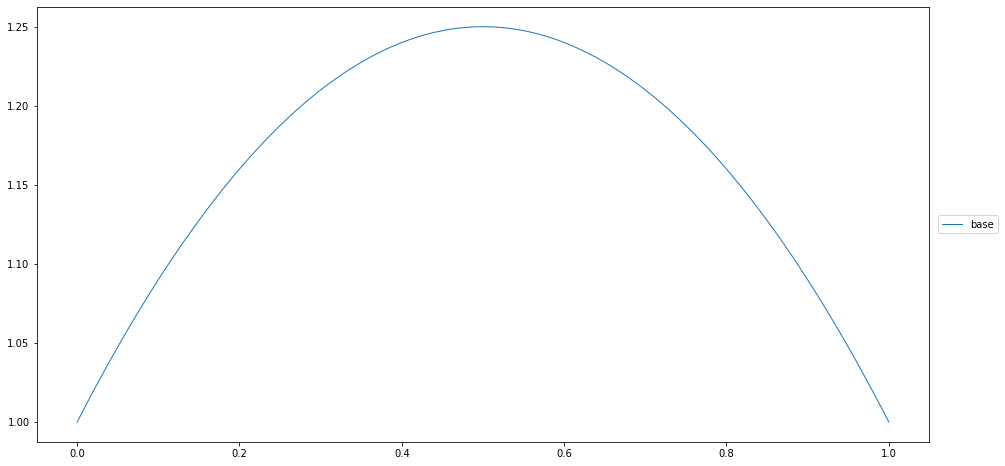

In [10]:
us =  problem.solve()
function_plots([Function(space, us,'base')])